# Preprocess research

In [437]:
import numpy as np
import scipy
from scipy.signal import butter, lfilter, lfilter_zi
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [438]:
def read_sample_data(path):
    with open(path, "r") as f:
        data = f.read()
    
    data = data.split(",")
    return np.array(data).astype(np.float32)
        

In [439]:
sample_data = read_sample_data("sample_data/raw_data.txt")
sample_prep_data = read_sample_data("sample_data/preprocessed_data.txt")

In [440]:
n_timesteps = 200 # 2 seconds at 100Hz
n_features = 3 # X, Y, Z

In [441]:
sample_data = sample_data.reshape(n_timesteps, n_features)

In [442]:
sample_prep_data = sample_prep_data.reshape(n_timesteps, n_features)

In [497]:
sample_prep_data = read_sample_data("sample_data/untitled.txt")
prepmic = sample_prep_data.reshape(n_timesteps, n_features)

In [505]:
np.where( np.abs(prepmic.flatten()) < 0.000001)

(array([150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
        163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175,
        176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188,
        189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
        202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214,
        215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227,
        228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240,
        241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253,
        254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266,
        267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279,
        280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292,
        293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305,
        306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318,
        319, 320, 321, 322, 323, 324, 325, 326, 327

## Raw data

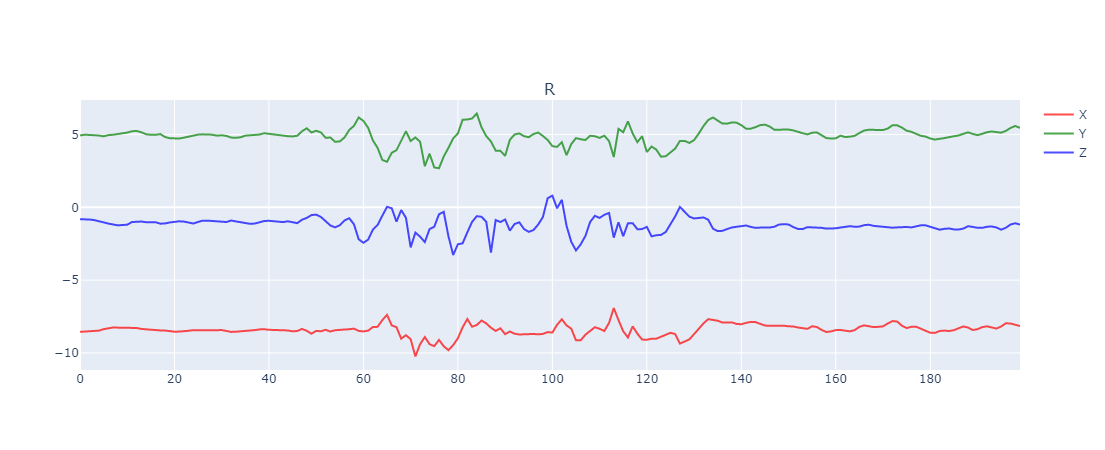

In [444]:
fig = make_subplots(rows=1, cols=1, subplot_titles=("Raw data") )

axes_names = ["X", "Y", "Z"]
colors = ["red", "green", "blue"]

x = np.arange(0, 200, 1)

for feature, axis_name, color in zip(sample_data.T, axes_names, colors):
    fig.add_trace(go.Scatter(x=x, y=feature, mode='lines', name=axis_name, opacity=0.7,
                 line =dict(color=color)),
                 row=1, col=1)
    
fig.show()

## Python preprocessing

In [478]:
def butter_lowpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = butter(order, low, btype='lowpass', output='ba')
    return b, a


def butter_lowpass_filter(data, lowcut, fs, order=5):
    b, a = butter_lowpass(lowcut, fs, order=order)
    #zi = lfilter_zi(b, a)
    #y, _ = lfilter(b, a, data, zi = zi*data[0])
    y = lfilter(b, a, data)
    return y

In [479]:
sampling_freq = 100
filter_order = 2
cutoff = 20

In [480]:
# Using libraries
def preprocess_high_level(data):
    data = data - data.mean(axis=0)
    
    data = data.T
    for i, ax in enumerate(data): # I could not vectorize it properly
        data[i] = butter_lowpass_filter(ax, cutoff, sampling_freq, filter_order)
    
    return data.T

We need the filter coefficents to implement our own discrete filter:

In [481]:
def print_tf(num, den, mode='z'):
    num_str = " + ".join(["{:.4f}{}^{}".format(el, mode, exp) for el, exp in zip(num.flatten(), range(len(num.flatten())-1, -1, -1)) if abs(el) > 1e-6])
    den_str = " + ".join(["{:.4f}{}^{}".format(el, mode, exp) for el, exp in zip(den.flatten(), range(len(den.flatten())-1, -1, -1)) if abs(el) > 1e-6])
    max_len = max(len(num_str), len(den_str))
    tf_str = " "*((max_len-len(num_str))//2) + num_str +"\n" + "-"*max_len+"\n" + " "*((max_len-len(den_str))//2) + den_str
  
    print(tf_str)

In [482]:
b, a = butter_lowpass(cutoff, sampling_freq, filter_order)
print_tf(b, a)

0.2066z^2 + 0.4131z^1 + 0.2066z^0
----------------------------------
1.0000z^2 + -0.3695z^1 + 0.1958z^0


In [483]:
b0, b1, b2 = b.flatten()
a0, a1, a2 = a.flatten()

In [484]:
# Now something more similar to what the C code will look like
def preprocess_mid_level(data):
    data = data - data.mean(axis=0)
    
    # C style filter
    xk1 = xk2 = yk1 = yk2 = 0
    x = data
    
    y_filterc = []
    for i in range(len(x)):
        xk = x[i]
        yk = (b0*xk + b1*xk1 + b2*xk2 - a1*yk1 - a2*yk2)

        yk2 = yk1
        yk1 = yk
        xk2 = xk1
        xk1 = xk

        y_filterc.append(yk)
    
    data = np.array(y_filterc)
    return data

# Comparison 

In [485]:
data_prep_high_level = preprocess_high_level(sample_data)
data_prep_mid_level = preprocess_mid_level(sample_data)

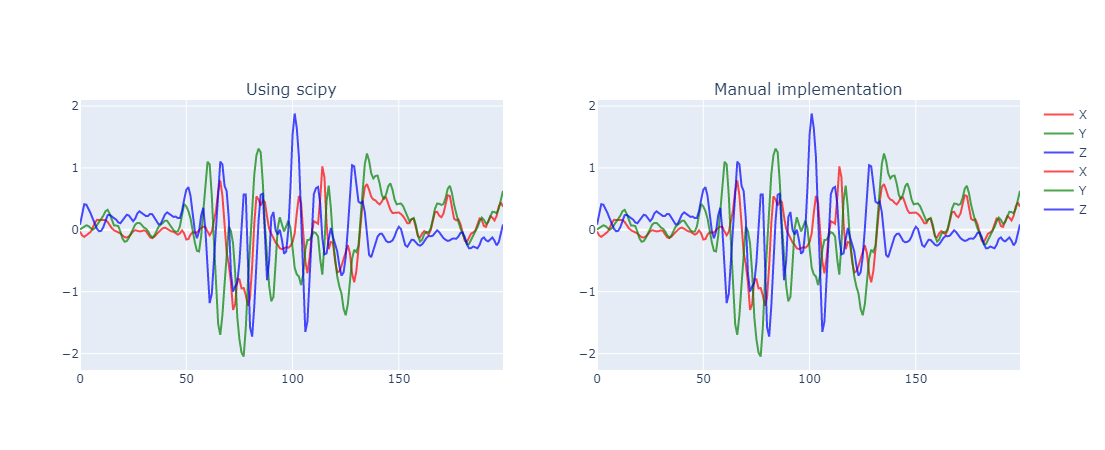

In [486]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Using scipy", "Manual implementation"))

axes_names = ["X", "Y", "Z"]
colors = ["red", "green", "blue"]

x = np.arange(0, 200, 1)

for feature, axis_name, color in zip(data_prep_high_level.T, axes_names, colors):
    fig.add_trace(go.Scatter(x=x, y=feature, mode='lines', name=axis_name, opacity=0.7,
                 line =dict(color=color)),
                 row=1, col=1)

for feature, axis_name, color in zip(data_prep_mid_level.T, axes_names, colors):
    fig.add_trace(go.Scatter(x=x, y=feature, mode='lines', name=axis_name, opacity=0.7,
                 line =dict(color=color)),
                 row=1, col=2)
    
fig.show()

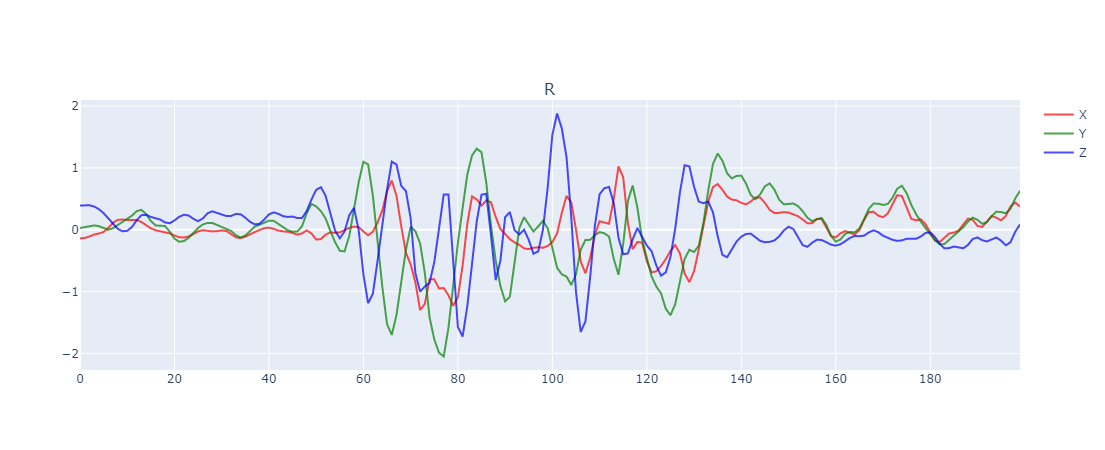

In [487]:
fig = make_subplots(rows=1, cols=1, subplot_titles=("Raw data") )

axes_names = ["X", "Y", "Z"]
colors = ["red", "green", "blue"]

x = np.arange(0, 200, 1)

for feature, axis_name, color in zip(sample_prep_data.T, axes_names, colors):
    fig.add_trace(go.Scatter(x=x, y=feature, mode='lines', name=axis_name, opacity=0.7,
                 line =dict(color=color)),
                 row=1, col=1)
    
fig.show()

Looks good, the only difference is in the initial conditions.

In [488]:
import tensorflow as tf

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="sample_data/model.lite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [494]:
# Test the model on random input data.
input_data = np.expand_dims(data_prep_mid_level.flatten(), axis=0)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
output_data

array([[0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.9961, 0.    , 0.    , 0.    , 0.    , 0.    ]],
      dtype=float32)

In [495]:
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)
print(data_prep_mid_level.flatten())

[-0.0283  0.0061  0.0812 -0.0903  0.0308  0.2767 -0.114   0.0622  0.4134
 -0.0859  0.073   0.4064 -0.0622  0.0597  0.3416 -0.0332  0.0252  0.2662
  0.0342  0.0007  0.1803  0.1142  0.0263  0.0913  0.1613  0.077   0.0159
  0.1659  0.12   -0.0227  0.1582  0.1646 -0.016   0.1599  0.2293  0.0452
  0.1566  0.3011  0.155   0.1268  0.3229  0.237   0.0747  0.2551  0.2414
  0.0254  0.1431  0.2087 -0.0066  0.0713  0.1893 -0.0253  0.0684  0.1658
 -0.0384  0.0609  0.1196 -0.058  -0.0301  0.1064 -0.0915 -0.1421  0.1516
 -0.119  -0.1924  0.2109 -0.1246 -0.1821  0.2433 -0.1077 -0.1292  0.2313
 -0.0679 -0.0513  0.1777 -0.0242  0.0292  0.1395 -0.0052  0.0865  0.1836
 -0.0136  0.1119  0.2667 -0.0257  0.1116  0.2992 -0.0213  0.0807  0.2778
 -0.0086  0.0397  0.2473 -0.0194  0.018   0.2224 -0.0682 -0.0186  0.2251
 -0.1209 -0.086   0.2564 -0.1343 -0.1247  0.2516 -0.1112 -0.092   0.1953
 -0.0723 -0.0132  0.1296 -0.0328  0.0516  0.0875 -0.0023  0.0816  0.0979
  0.025   0.1112  0.1666  0.036   0.1476  0.2493  0